<!--# STAT 207: Data Science Exploration-->
# Regularized Logistic Regression and Cross-Validation

Regularized regression methods are designed to improve modeling of high dimensional data by incorporating a penalty function to drive variable selection. The Python Scikit-Learn library includes regularized regression and regularized logisitic regression as standard model optimization methods. This section will provide a breif overview of penalized logistic regression and demonstrate how the methods work on simulated data. 

In order to evaluate the classification accuracy of regularized logistic regression we can use the 
Train/Test method to avoid optimistic bias. One limitation is that it uses only part of the data for both model building and for assessment.

An extension of simple Train/Test is **cross-validation.** This method uses all of the data by repeated application of train/test splitting. The results are then averaged to improve the accuracy. The approach also gives us a simple way to estimate the uncertainty of the accuracy estiamte.

The oldest such method is **leave-one-out cross-validation**, where each of the $n$ observations in a sample is omitted in turn. The estimate is recomputed for each of the $n$ subsets of size $n-1$. The resulting $n$ predictions are then used to estimate predictive accuracy.

Modern methods use **k-fold cross-validation**, where the data are split into $k$ subsets. $k-1$ subsets are used for training, and the left out subset is used for testing. This is repeated at least $k$ times, leaving out each of the $k$ subsets in turn. 

The random selection of the $k$ subsets can itself be repeated to generate multiple $k$ fold splits, thus avoiding over dependence on one particular random split.

To use these methods efficiently in Python, we first discuss the structure of models in the machine learning library Scikit-Learn. Then we illustrate some of the cross validation capabilities in the library.

### Model building with Scikit-Learn

Unlike the statsmodels API, which is formula based and operates on pandas data frames, the machine learning functions in the Scikit-Learn expect data to be encoded as numerical matrices: 

1. The **features matrix** $X$ is an array with $n$ rows of observations and $p$ columns of features (exogenous variables);

2. The **target array** $y$ is an array with elements that serve as "labels" for the $n$ observations.



**Features matrix $X$:** We can think of the features matrix as a data frame containing only exogenous variables. Sci-kit learn modules generally expect $X$ to contain only numerical columns. Therefore it provides preprocessing functions to

+ Convert categorical and boolean data into numerically coded columns (e.g. 0/1 indicator columns)


+ Add a column of 1s for the intercept if desired



**Target array $y$:** This is our array of labels, i.e., response data that will be used to train the model. It may be categorical (0/1) as in classification problems and logistic regression, or have continuous numerical values as in linear regression.

**Supervised learning**: When we have a target array $y$, its elements **label** the corresponding rows of $X$. The two main types of labels are:

1. **Categorical (0/1) labels:** these correspond to **classification problems**, where the labels are said to **supervise** the modeling of how information in $X$ can be used for training the classifier.


2. **Continuous numerical labels:** these correspond to **predictive regression problems** such as linear regresssion or regularized regresssion, where the goal is to predict numerical responses. The numerical $y$ labels **supervise** training of the regression model, e.g., by minimizing and ordinary or penalized least squares criterion.

**Unsupervised learning:** if we have unlabeled data, so $y$ is not available, we can no longer classify the rows of $X$, however, it is often of interest to detect **clusters** of samples in $X$ based on some assumptions about how subpopulations might separate. Applications include $k$-means clustering and mixtures of Gaussian distributions.

This section focuses on supervised model building, but generalizing train/test methods to k-fold cross-validation.

#### Modeling steps in the modeling/machine learning process

Scikit-Learn are designed to faciliate a regular sequence of modeling steps:

1. Choose the model class for the problem and import the Scikit-Learn estimator class

2. Choose model hyperparameters to create an instance of the class (more later)

3. Organize data into the features matri $X$ and target array $y$

4. Train the model using the .fit() method

5. Test the model on new or test data using the .predict() method

For extensive further discussion, see VanDerPlas, Chapter 5. We cover the basics with some examples here.

### Simulated data with 20 features and binary target

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, bernoulli

In [2]:
## make a coefficient vector for logit model
b0 = -1  # intercept
bvec = np.repeat([1,-1,0], [5, 5, 10])  # feature coefficients
n = 200
nX = bvec.size

Xmat = norm.rvs(size=n*nX, random_state=1).reshape((n, nX))
# Generate X and add the column names
##X = pd.DataFrame(
##    norm.rvs(size=n*nX, random_state=1).reshape((n, nX)), 
##    columns=Xnames)
# Now generate the target array using X and the coefficient vector
odds = np.exp(b0 + np.matmul(Xmat, bvec)) # use matrix multiplication
y = bernoulli.rvs(p=odds/(1+odds), size=n, random_state=12347)
# load X into data frame with names
Xnames = []
for i in range(nX):
    list.append(Xnames, 'X'+str(i))
X = pd.DataFrame(Xmat, columns=Xnames)
display(X.shape, y.shape)

(200, 20)

(200,)

Can we visualize the data somehow? Let try to compare mean X features between the two groups (y=0 and y=1).

In [3]:
mean_matrix = np.array((X[y==0].mean(), X[y==1].mean()))
display(mean_matrix.shape, mean_matrix)

(2, 20)

array([[-2.22157664e-01, -2.04966538e-01, -2.43240376e-01,
        -3.63570421e-02, -1.93845863e-01,  9.36729581e-02,
         2.62709812e-01,  2.13169647e-01,  2.00029658e-01,
         4.63842261e-02,  7.77167483e-02, -6.72668629e-02,
         4.06244529e-04,  9.16813708e-02,  9.95053160e-02,
        -6.73780626e-02,  9.83761988e-02, -9.47603953e-02,
        -6.94209204e-02,  4.91980066e-02],
       [ 2.25164206e-01,  2.82792473e-01,  2.80512385e-01,
         4.03376804e-01,  1.78792096e-01, -4.00832721e-01,
        -1.61412650e-01, -1.31933518e-01, -8.48852940e-02,
        -4.39996214e-01,  7.77267095e-02,  2.42083521e-01,
         4.56481738e-02,  2.79365255e-02, -2.91626160e-01,
         4.88051708e-02,  3.90577553e-02, -1.18110230e-02,
         9.25214471e-02,  1.95490706e-01]])

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

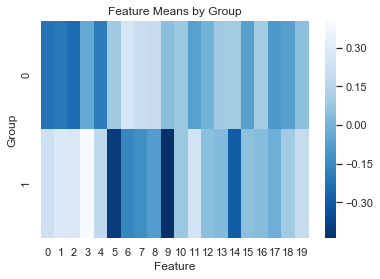

In [5]:
sns.heatmap(mean_matrix, annot=False, linewidths=0, 
            square = False, cmap = 'Blues_r');
plt.ylabel('Group');
plt.xlabel('Feature');
all_sample_title = 'Feature Means by Group'
plt.title(all_sample_title, size = 12);
plt.show()

We can see that the two groups differ in their patterns of mean feature values. This is a reflection of how the different features contribute to the logit model through the coefficient vector weighting of features to generate 0/1 responses.

### Brief Explanation of Regularized Logistic Regression

In previous sections we used the Statmodels formula API to fit linear and logistic regression models. The advantage of the statsmodels API is in the amount of information it provides about model parameters, standard errors and hypothesis testing. Statsmodels is the current preferred choice if our goal is to make inferences about the model parameters. 

As an alternative, Scikit-Learn provides machine learning tools focused on predictive analysis. The characteristics:

* Integration with machine learning tools for **cross-validation**;

* Routine implementation of **regularization** for modeling with high-dimensional feature matrices;

* Several choices for numerical optimizers for solving regularized regression problems.


Regularization penalties automate feature selection to some extent, as an alternative to tracking AIC or BIC. 

First consider "ordinary" **maximum likelihood estimation** for the logistic regression. We solve numerically for the coefficient estimates using a numerical optimization method such as a quasi-newton algorithm. The solver maximizes the log-likelihood, equivalently, minimizes twice the negative log likelihood:


\begin{align*}
\text{Likelihood fit} & = -2* {llf} = -2*LLF(\hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_p) \\ \\
&= -2 \sum_{i=1}^n \{ y_i \log(\hat{p}_i) + (1-y_i) \log(1-\hat{p}_i)\}\\ \\
& \ge 0.\\
\end{align*}


If we compare models with different numbers of coefficients using BIC, for example, we are attempting to minimize an overall criterion of the form:

$$
-2 * llf + p*\log(n) = \text{likelihood fit} + \text{complexity penalty}
$$



**Regularization penalties** combine the likelihood criterion and the penalty into one optimization criterion for estimating the feature coefficients. For a given level of complexity this can produce fitted models with better mean-square error predictive properties. Here a few choices that are currently in common use:

+ **L2 penalty (Ridge regression):**  Shrinks parameters toward smaller absolute values to reduce variance. In linear regression this is called ridge regression. $\lambda$ controls tradeoff between fit and shrinkage. It reduces the effect of correlation between features, which is an issue in high dimensions.

$$
\text{Minimize: } (-2*llf) + \lambda \sum_{j=1}^p \hat{\beta}_j^2
$$




+ **L1 penalty (LASSO):** Produces sparse solutions (small number of nonzero parameters) by zeroing out some parameters. $\lambda$ controls tradeoff between fit and sparsity. This method directly reduces redundant features. 

$$
\text{Minimize: } (-2*llf) + \lambda \sum_{j=1}^p \vert \hat{\beta}_j \vert
$$



+ **Elastic Net penalty (Combination):**  Combines L1 and L2 penalization ro produce sparse, low variance solutions. $\lambda$ controls the tradeoff between fit and peanlization. $\alpha \in [0,1]$ controls the relative weight of L1 versus L2 penalization.

$$
\text{Minimize: } (-2*llf) + \lambda \left(\alpha \sum_{j=1}^p \vert \hat{\beta}_j \vert 
+ {1-\alpha \over 2} \sum_{j=1}^p \hat{\beta}_j^2 \right)
$$


The current default setting in the Scikit-Learn LogisticRegression module is L1 regularization. The function sets the degree of penalization using the input C, which is inversely related to $\lambda$. The default setting is C=1. Smaller values of C correspond to heavier regularization or more sparsity in the solution.

### Example: comparison of regularized coefficient estimates using different penalties

Using our simulated data with 20 features, let's compare for 4 different options for regularization: None, L1 penalty, L2 penalty, and Elastic Net.

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
C=0.3  # set the amount of penalization (1/lambda)
clf0 = LogisticRegression('none', solver='newton-cg', 
                          max_iter=1000)
clf0.fit(X,y)
clf1 = LogisticRegression('l1', solver='liblinear', 
                          max_iter=1000, C=C)
clf1.fit(X,y)
clf2 = LogisticRegression('l2', solver='liblinear', 
                          max_iter=1000, C=C)
clf2.fit(X,y)
clf3 = LogisticRegression('elasticnet', solver='saga', 
                          max_iter=1000, l1_ratio=0.7, C=C)
clf3.fit(X,y)

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.7, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
dfcoef = pd.DataFrame(
    np.concatenate((clf0.coef_.T, clf1.coef_.T, clf2.coef_.T, clf3.coef_.T), 
                   axis=1)
)
dfcoef

,0,1,2,3
0,2.448386,0.862791,0.943341,0.913333
1,2.099151,0.794783,0.852618,0.840932
2,1.911414,0.789600,0.869266,0.832854
3,1.763950,0.590459,0.706093,0.658123
4,1.011388,0.462532,0.549192,0.501242
5,-2.277685,-0.818757,-0.893153,-0.877069
6,-1.817789,-0.713696,-0.773147,-0.739542
7,-1.840509,-0.684418,-0.776345,-0.730758
8,-1.400668,-0.493051,-0.588224,-0.531202
9,-2.610932,-0.890014,-1.001949,-0.978463


Graphical comparison:

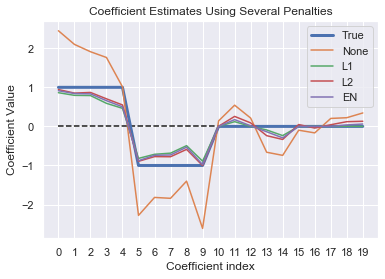

In [9]:
plt.plot(dfcoef.index, bvec, lw=3)
plt.plot(dfcoef.index, dfcoef[0])
plt.plot(dfcoef.index, dfcoef[1])
plt.plot(dfcoef.index, dfcoef[2])
plt.plot(dfcoef.index, dfcoef[3])
plt.xticks(np.arange(0,20,1))
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Estimates Using Several Penalties')
plt.legend(['True', 'None','L1','L2','EN'], loc='upper right')
plt.hlines(y=0, xmin=0, xmax=19, linestyles='--')
plt.show()

We see that the unregularized ML coefficients have the most variation, and appear to stray farther from the true population values than the regularized estimators. The penalized estimators are biased toward zero, which reduces variation amd also appears to improve their accruacy. Where the coefficients are close to zero, L1 and ElasticNet zero them out.

Note: C=1 is the default setting for the amount of penalization. Smaller values of C increase the amount of penalization. Here we used C=0.3

### Regularized Logistic Regression with Train/Test split in Sci-Kit Learn

We illustrate using the simulated binary response data. We'll generate the feature matrix $X$ and a binary target array $y$ from a logistic regression model with 20 features.

1. Import the model class:

In [10]:
from sklearn.linear_model import LogisticRegression

2. Create an instance of the model. We'll use an 'l1' penalty to regularize the regression for this example.

In [11]:
logitReg = LogisticRegression(penalty='l1', solver='liblinear', C=1, max_iter=1000)

3. Train the model (we'll use a five-fold split)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [14]:
logitReg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

4. Get predictions for test data

In [15]:
yhat = logitReg.predict(X_test)

In [16]:
yhat

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0])

5. Evaluate the results

In [17]:
# Accuracy:
score = logitReg.score(X_test, y_test)
score

0.825

In [18]:
# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import metrics

In [19]:
# rows are actual labels (0, 1), columns are predicted label (0,1)
cm = metrics.confusion_matrix(y_test, yhat)
cm

array([[24,  3],
       [ 4,  9]], dtype=int64)

Here's a more visual confusion matrix. Code adapted from: ([Galarnyk, 2017](https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a))

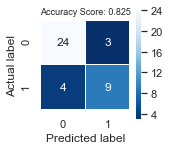

In [20]:
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, 
            square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 9);
plt.show()

### Cross Validation Scoring of Regularized Classifiers

In [21]:
from sklearn.model_selection import cross_val_score

#### Without regularization

In [22]:
modclass0 = LogisticRegression(penalty='none', solver='newton-cg')
scores0 = cross_val_score(modclass0, X, y, cv=5)
scores0

array([0.825, 0.675, 0.8  , 0.85 , 0.9  ])

In [23]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores0.mean(), 2*scores0.std()/np.sqrt(5)))

Accuracy: 0.81 (+/- 0.07)


#### Using L1 regularization

In [24]:
modclass1 = LogisticRegression(penalty='l1', solver='saga', C=0.3, max_iter=1000)
scores1 = cross_val_score(modclass1, X, y, cv=5)
scores1

array([0.825, 0.75 , 0.8  , 0.8  , 0.85 ])

In [25]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), 2*scores1.std()/np.sqrt(5)))

Accuracy: 0.80 (+/- 0.03)


#### Using L2 regularization

In [26]:
modclass2 = LogisticRegression(penalty='l2', solver='saga', C=0.3, max_iter=1000)
scores2 = cross_val_score(modclass2, X, y, cv=5)
scores2

array([0.825, 0.75 , 0.8  , 0.85 , 0.9  ])

In [27]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), 2*scores2.std()/np.sqrt(5)))

Accuracy: 0.82 (+/- 0.04)


#### Using Elastic Net regularization

In [28]:
modclass3 = LogisticRegression(penalty='elasticnet', solver='saga', 
                               l1_ratio=0.75, C=0.3, max_iter=1000)
scores3 = cross_val_score(modclass3, X, y, cv=5)
scores3

array([0.825, 0.75 , 0.825, 0.85 , 0.85 ])

In [29]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores3.mean(), 2*scores3.std()/np.sqrt(5)))

Accuracy: 0.82 (+/- 0.03)


---
STAT 207, Douglas Simpson, University of Illinois at Urbana-Champaign